In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense,Dropout
from sklearn.preprocessing import MinMaxScaler

In [57]:
def dates_close_features(df,stock_number):
    close_col = 'Close-Stock-' + str(stock_number)
    oc_spread = 'OC'+str(stock_number)
    df['Date'] = pd.to_datetime(df['Date'])
    features = df.set_index('Date')
    dates = df['Date'].copy()
    close_prices = pd.DataFrame(features[close_col].copy())
    features.drop(close_col,inplace = True,axis = 1)
    features.drop(oc_spread,inplace = True,axis = 1)
    return dates,close_prices,features

In [117]:
def Scale(df,scaler = None):
    cols = df.columns.values
    idxes = df.index
    if scaler == None:
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(df)
    else:
        scaled = scaler.transform(df)
    result = pd.DataFrame(scaled)
    result.columns = cols
    result.set_index(idxes,inplace = True)
    return result,scaler

In [5]:
def read_data(filepath):
    df = pd.read_csv(filepath)
    return df

In [6]:
def preprocess_x(df,past_days):
    rows = df.shape[0]
    x_variables = df.shape[1]
    reshaped = np.array(df[0:past_days]).reshape(1,past_days,x_variables)
    #leaves last column as we don't have training data for last column
    for i in range(1,rows-past_days):
        b = np.array(df[i:i + past_days]).reshape(1,past_days,x_variables)
        reshaped = np.append(reshaped,b,axis= 0)
    return reshaped

In [7]:
def preprocess_y(df,past_days):
    res = df[past_days:]
    return res

In [17]:
def train_val_test_split(df):
    last_idx = df.shape[0]
    train_idx = int(0.7*last_idx)
    val_idx = int(0.9*last_idx)
    train_set = df[0:train_idx].copy()
    val_set = df[train_idx:val_idx].copy()
    test_set = df[val_idx:last_idx].copy()
    print('Indexes for train,val and test set')
    print((0,train_idx-1),(train_idx,val_idx-1),(val_idx,last_idx-1))
    return train_idx,val_idx,train_set,val_set,test_set

In [178]:
def rmse(actual,prediction,label = ''):
    plt.plot(actual)
    plt.plot(prediction)
    print(label)
    print('Test RMSE: %.3f' % sqrt(mean_squared_error(actual,prediction)))

In [148]:
def read_test(filepath,stock_n):
    n = str(stock_n)
    columns = ['Open-Stock-'+n,'High-Stock-'+n,'Low-Stock-'+n,
        'VWAP-Stock-'+n,'Turnover-Stock-'+n,'Volume-Stock-'+n,'HL'+n]
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date',inplace = True)
    df = df[columns]
    return df

In [157]:
def append_past_days_data(data,past_data,past_days):
    new_data = past_data[-past_days:].append(data)
    return new_data

In [83]:
submission_col = pd.read_csv('data/new_sample_submission.csv').columns
submission_idx = pd.to_datetime(pd.read_csv('data/new_test.csv')['Date'])
submission = pd.DataFrame(index= submission_idx,columns= submission_col)
submission.drop('Date',axis = 1, inplace = True)
submission.fillna(0.0,inplace=True)
submission.head()

,Close-Stock-1,Close-Stock-2,Close-Stock-3,Close-Stock-4,Close-Stock-5
Date,,,,,
2011-08-04,0.0,0.0,0.0,0.0,0.0
2011-08-05,0.0,0.0,0.0,0.0,0.0
2011-08-08,0.0,0.0,0.0,0.0,0.0
2011-08-09,0.0,0.0,0.0,0.0,0.0
2011-08-10,0.0,0.0,0.0,0.0,0.0


## Stock 1

In [8]:
s1 = read_data('data/stocks_train/stock_1.csv')
s1.head()

,Date,Open-Stock-1,Close-Stock-1,High-Stock-1,Low-Stock-1,VWAP-Stock-1,Turnover-Stock-1,Volume-Stock-1,OC1,HL1
0,2010-06-01,1889.7,1855.10,1890.00,1838.00,1855.75,105457457545000,568273,34.60,52.00
1,2010-06-02,1848.0,1853.05,1862.75,1828.00,1842.82,174177161135000,945167,-5.05,34.75
2,2010-06-03,1864.1,1905.60,1910.00,1864.10,1893.91,128727119355000,679689,-41.50,45.90
3,2010-06-04,1906.0,1885.70,1909.80,1880.10,1889.21,96242800140000,509435,20.30,29.70
4,2010-06-07,1867.0,1876.65,1894.85,1808.35,1873.32,180196832650000,961913,-9.65,86.50


In [58]:
all_dates,unscaled_close_p,unscaled_params = dates_close_features(s1,1)
unscaled_params.shape,unscaled_close_p.shape,all_dates.shape

((299, 7), (299, 1), (299,))

In [59]:
unscaled_params.head()

,Open-Stock-1,High-Stock-1,Low-Stock-1,VWAP-Stock-1,Turnover-Stock-1,Volume-Stock-1,HL1
Date,,,,,,,
2010-06-01,1889.7,1890.00,1838.00,1855.75,105457457545000,568273,52.00
2010-06-02,1848.0,1862.75,1828.00,1842.82,174177161135000,945167,34.75
2010-06-03,1864.1,1910.00,1864.10,1893.91,128727119355000,679689,45.90
2010-06-04,1906.0,1909.80,1880.10,1889.21,96242800140000,509435,29.70
2010-06-07,1867.0,1894.85,1808.35,1873.32,180196832650000,961913,86.50


In [60]:
unscaled_close_p.head()

,Close-Stock-1
Date,
2010-06-01,1855.10
2010-06-02,1853.05
2010-06-03,1905.60
2010-06-04,1885.70
2010-06-07,1876.65


In [61]:
params,param_scaler = Scale(unscaled_params)
close,close_scaler = Scale(unscaled_close_p)

In [62]:
params.head()

,Open-Stock-1,High-Stock-1,Low-Stock-1,VWAP-Stock-1,Turnover-Stock-1,Volume-Stock-1,HL1
Date,,,,,,,
2010-06-01,0.675993,0.669132,0.655533,0.657724,0.204381,0.099529,0.248259
2010-06-02,0.656015,0.656128,0.650720,0.651534,0.350606,0.170437,0.152132
2010-06-03,0.663728,0.678677,0.668095,0.675993,0.253896,0.120490,0.214266
2010-06-04,0.683802,0.678582,0.675795,0.673742,0.184774,0.088459,0.123990
2010-06-07,0.665118,0.671447,0.641262,0.666135,0.363415,0.173588,0.440513


In [63]:
close.head()

,Close-Stock-1
Date,
2010-06-01,0.658932
2010-06-02,0.657948
2010-06-03,0.683167
2010-06-04,0.673617
2010-06-07,0.669274


In [64]:
reshaped_params = preprocess_x(params,2)
reshaped_params.shape

(297, 2, 7)

In [65]:
y = preprocess_y(close,2)
y.shape

(297, 1)

In [66]:
t_idx,v_idx,train_x,val_x,test_x = train_val_test_split(reshaped_params)

Indexes for train,val and test set
(0, 206) (207, 266) (267, 296)


In [67]:
t_i,v_i,train_y,val_y,test_y = train_val_test_split(y)

Indexes for train,val and test set
(0, 206) (207, 266) (267, 296)


In [68]:
train_x.shape,train_y.shape

((207, 2, 7), (207, 1))

In [75]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(train_x.shape[1],train_x.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = "mean_squared_error",optimizer="adam")

In [76]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 2, 50)             11600     
_________________________________________________________________
lstm_16 (LSTM)               (None, 2, 50)             20200     
_________________________________________________________________
lstm_17 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 52,051
Trainable params: 52,051
Non-trainable params: 0
_________________________________________________________________


In [77]:
history = model.fit(train_x,train_y,validation_data=(val_x,val_y),epochs=500,batch_size=23,verbose = 1)

 - val_loss: 3.8368e-04
Epoch 316/500
9/9 [==============================] - 0s 24ms/step - loss: 5.2675e-04 - val_loss: 7.5240e-04
Epoch 317/500
9/9 [==============================] - 0s 25ms/step - loss: 5.9344e-04 - val_loss: 6.8867e-04
Epoch 318/500
9/9 [==============================] - 0s 24ms/step - loss: 6.4647e-04 - val_loss: 3.5797e-04
Epoch 319/500
9/9 [==============================] - 0s 25ms/step - loss: 6.3246e-04 - val_loss: 3.6204e-04
Epoch 320/500
9/9 [==============================] - 0s 28ms/step - loss: 5.4591e-04 - val_loss: 4.3652e-04
Epoch 321/500
9/9 [==============================] - 0s 25ms/step - loss: 5.8242e-04 - val_loss: 6.2289e-04
Epoch 322/500
9/9 [==============================] - 0s 25ms/step - loss: 7.2522e-04 - val_loss: 3.3911e-04
Epoch 323/500
9/9 [==============================] - 0s 25ms/step - loss: 5.4134e-04 - val_loss: 6.1709e-04
Epoch 324/500
9/9 [==============================] - 0s 25ms/step - loss: 5.1847e-04 - val_loss: 3.4746e-04
Epoc

In [78]:
raw_train_predictions = model.predict(train_x)
raw_val_predictions = model.predict(val_x)
raw_test_predictions = model.predict(test_x)

In [79]:
train_predictions = close_scaler.inverse_transform(raw_train_predictions)
val_predictions = close_scaler.inverse_transform(raw_val_predictions)
test_predictions = close_scaler.inverse_transform(raw_test_predictions)
train_prices =  close_scaler.inverse_transform(train_y)
val_prices = close_scaler.inverse_transform(val_y)
test_prices = close_scaler.inverse_transform(test_y)

Test RMSE: 43.617


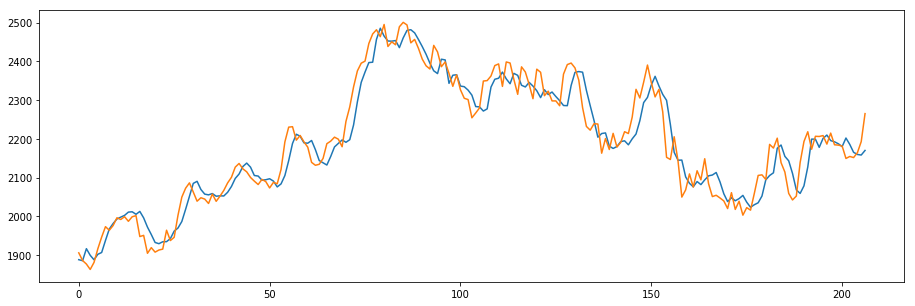

In [80]:
plt.figure(figsize=(15.5,5))
rmse(train_predictions,train_prices)

Test RMSE: 38.645


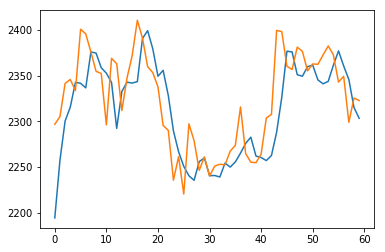

In [81]:
rmse(val_predictions,val_prices)

Test RMSE: 502.257


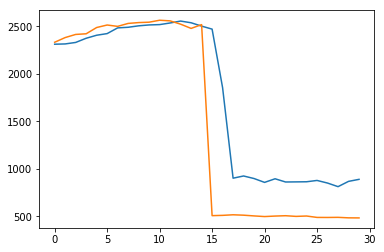

In [82]:
rmse(test_predictions,test_prices)

In [162]:
raw_test = read_test('data/stocks_test/stock_1.csv',1)
raw_test = append_past_days_data(raw_test,unscaled_params,2)
scaled_raw_test = Scale(raw_test,param_scaler)[0]
test = preprocess_x(scaled_raw_test,2)
test.shape

(97, 2, 7)

In [171]:
raw_submission_predictions = model.predict(test)
submission_predictions = close_scaler.inverse_transform(raw_submission_predictions)
pd.DataFrame(submission_predictions).describe().T

,count,mean,std,min,25%,50%,75%,max
0,97.0,828.804871,52.74791,658.5578,801.680603,836.863647,870.105713,901.2901


In [175]:
submission['Close-Stock-1'] = pd.DataFrame(submission_predictions).set_index(submission.index)

In [177]:
submission.head()

,Close-Stock-1,Close-Stock-2,Close-Stock-3,Close-Stock-4,Close-Stock-5
Date,,,,,
2011-08-04,890.214905,0.0,0.0,0.0,0.0
2011-08-05,889.428833,0.0,0.0,0.0,0.0
2011-08-08,879.970703,0.0,0.0,0.0,0.0
2011-08-09,832.845947,0.0,0.0,0.0,0.0
2011-08-10,804.529968,0.0,0.0,0.0,0.0


## Stock 2

In [181]:
s2 = read_data('data/stocks_train/stock_2.csv')
s2.head()

,Date,Open-Stock-2,Close-Stock-2,High-Stock-2,Low-Stock-2,VWAP-Stock-2,Turnover-Stock-2,Volume-Stock-2,OC2,HL2
0,2010-06-01,285.40,283.00,285.95,281.50,283.72,90557243170000,3191773,2.4,4.45
1,2010-06-02,284.00,281.30,284.80,279.25,281.05,76017076445000,2704797,2.7,5.55
2,2010-06-03,283.00,285.50,286.85,282.50,285.34,71043460510000,2489752,-2.5,4.35
3,2010-06-04,288.85,290.85,291.80,277.00,289.81,92414802585000,3188813,-2.0,14.80
4,2010-06-07,285.00,287.70,289.10,285.00,287.01,63109395135000,2198836,-2.7,4.10


In [182]:
all_dates,unscaled_close_p,unscaled_params = dates_close_features(s2,2)
unscaled_params.shape,unscaled_close_p.shape,all_dates.shape

((299, 7), (299, 1), (299,))

In [183]:
params,param_scaler = Scale(unscaled_params)
close,close_scaler = Scale(unscaled_close_p)

In [184]:
reshaped_params = preprocess_x(params,2)
reshaped_params.shape

(297, 2, 7)

In [185]:
y = preprocess_y(close,2)
y.shape

(297, 1)

In [186]:
t_idx,v_idx,train_x,val_x,test_x = train_val_test_split(reshaped_params)

Indexes for train,val and test set
(0, 206) (207, 266) (267, 296)


In [187]:
t_i,v_i,train_y,val_y,test_y = train_val_test_split(y)

Indexes for train,val and test set
(0, 206) (207, 266) (267, 296)


In [188]:
train_x.shape,train_y.shape

((207, 2, 7), (207, 1))

In [189]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(train_x.shape[1],train_x.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = "mean_squared_error",optimizer="adam")

In [198]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 2, 50)             11600     
_________________________________________________________________
lstm_19 (LSTM)               (None, 2, 50)             20200     
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 52,051
Trainable params: 52,051
Non-trainable params: 0
_________________________________________________________________


In [199]:
history = model.fit(train_x,train_y,validation_data=(val_x,val_y),epochs=500,batch_size=23,verbose = 1)

: 0.0042 - val_loss: 3.6483e-04
Epoch 309/500
9/9 [==============================] - 0s 35ms/step - loss: 0.0040 - val_loss: 3.8465e-04
Epoch 310/500
9/9 [==============================] - 0s 28ms/step - loss: 0.0042 - val_loss: 4.8707e-04
Epoch 311/500
9/9 [==============================] - 0s 25ms/step - loss: 0.0041 - val_loss: 3.6962e-04
Epoch 312/500
9/9 [==============================] - 0s 26ms/step - loss: 0.0040 - val_loss: 3.8351e-04
Epoch 313/500
9/9 [==============================] - 0s 25ms/step - loss: 0.0042 - val_loss: 3.8474e-04
Epoch 314/500
9/9 [==============================] - 0s 23ms/step - loss: 0.0043 - val_loss: 3.9204e-04
Epoch 315/500
9/9 [==============================] - 0s 29ms/step - loss: 0.0042 - val_loss: 4.1989e-04
Epoch 316/500
9/9 [==============================] - 0s 26ms/step - loss: 0.0041 - val_loss: 3.7634e-04
Epoch 317/500
9/9 [==============================] - 0s 25ms/step - loss: 0.0040 - val_loss: 3.7419e-04
Epoch 318/500
9/9 [=============

In [200]:
raw_train_predictions = model.predict(train_x)
raw_val_predictions = model.predict(val_x)
raw_test_predictions = model.predict(test_x)

In [201]:
train_predictions = close_scaler.inverse_transform(raw_train_predictions)
val_predictions = close_scaler.inverse_transform(raw_val_predictions)
test_predictions = close_scaler.inverse_transform(raw_test_predictions)
train_prices =  close_scaler.inverse_transform(train_y)
val_prices = close_scaler.inverse_transform(val_y)
test_prices = close_scaler.inverse_transform(test_y)


Test RMSE: 9.926


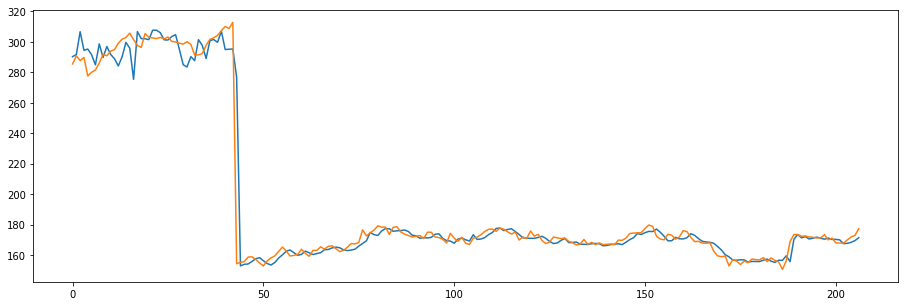

In [202]:
plt.figure(figsize=(15.5,5))
rmse(train_predictions,train_prices)


Test RMSE: 3.357


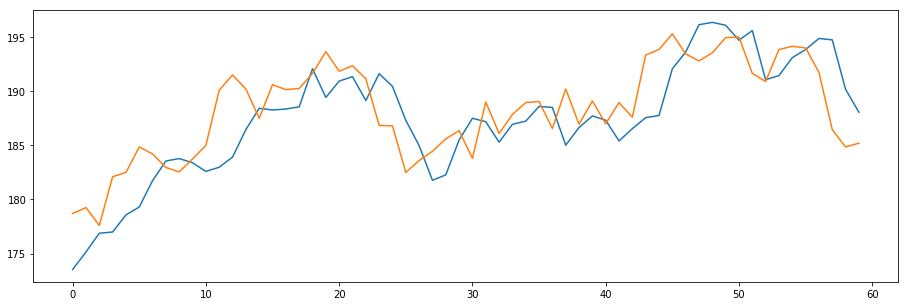

In [203]:
plt.figure(figsize=(15.5,5))
rmse(val_predictions,val_prices)


Test RMSE: 5.032


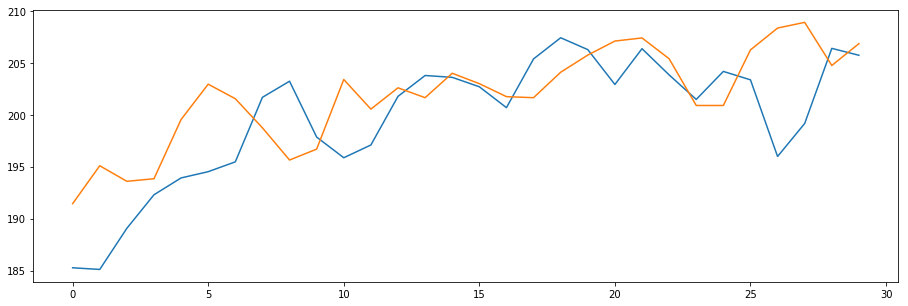

In [204]:
plt.figure(figsize=(15.5,5))
rmse(test_predictions,test_prices)

In [208]:
raw_test = read_test('data/stocks_test/stock_2.csv',2)
raw_test = append_past_days_data(raw_test,unscaled_params,2)
scaled_raw_test = Scale(raw_test,param_scaler)[0]
test = preprocess_x(scaled_raw_test,2)
test.shape

(97, 2, 7)

In [209]:
raw_submission_predictions = model.predict(test)
submission_predictions = close_scaler.inverse_transform(raw_submission_predictions)
pd.DataFrame(submission_predictions).describe().T

,count,mean,std,min,25%,50%,75%,max
0,97.0,200.664261,6.605888,187.596344,196.833435,199.952911,205.410248,216.867661


In [210]:
submission['Close-Stock-2'] = pd.DataFrame(submission_predictions).set_index(submission.index)
submission.head()

,Close-Stock-1,Close-Stock-2,Close-Stock-3,Close-Stock-4,Close-Stock-5
Date,,,,,
2011-08-04,890.214905,205.371414,0.0,0.0,0.0
2011-08-05,889.428833,201.313705,0.0,0.0,0.0
2011-08-08,879.970703,192.768097,0.0,0.0,0.0
2011-08-09,832.845947,192.253708,0.0,0.0,0.0
2011-08-10,804.529968,191.535629,0.0,0.0,0.0


## Stock 3

In [211]:
s3 = read_data('data/stocks_train/stock_3.csv')
s3.head()

,Date,Open-Stock-3,Close-Stock-3,High-Stock-3,Low-Stock-3,VWAP-Stock-3,Turnover-Stock-3,Volume-Stock-3,OC3,HL3
0,2010-06-01,2095.00,2077.25,2097.8,2045.00,2088.95,14736933230000,70547,17.75,52.80
1,2010-06-02,2061.45,2079.85,2098.0,2023.00,2059.52,11440017990000,55547,-18.40,75.00
2,2010-06-03,2131.50,2114.90,2131.5,2091.05,2107.84,11620529360000,55130,16.60,40.45
3,2010-06-04,2114.90,2146.75,2156.0,2095.50,2145.36,6286330280000,29302,-31.85,60.50
4,2010-06-07,2132.35,2185.25,2209.0,2112.00,2180.52,17208425860000,78919,-52.90,97.00


In [212]:
all_dates,unscaled_close_p,unscaled_params = dates_close_features(s3,3)
unscaled_params.shape,unscaled_close_p.shape,all_dates.shape

((299, 7), (299, 1), (299,))

In [213]:
params,param_scaler = Scale(unscaled_params)
close,close_scaler = Scale(unscaled_close_p)

In [252]:
reshaped_params = preprocess_x(params,2)
reshaped_params.shape

(297, 2, 7)

In [253]:
y = preprocess_y(close,2)
y.shape

(297, 1)

In [254]:
t_idx,v_idx,train_x,val_x,test_x = train_val_test_split(reshaped_params)

Indexes for train,val and test set
(0, 206) (207, 266) (267, 296)


In [255]:
t_i,v_i,train_y,val_y,test_y = train_val_test_split(y)

Indexes for train,val and test set
(0, 206) (207, 266) (267, 296)


In [256]:
train_x.shape,train_y.shape

((207, 2, 7), (207, 1))

In [257]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(train_x.shape[1],train_x.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = "mean_squared_error",optimizer="adam")

In [258]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 2, 50)             11600     
_________________________________________________________________
lstm_28 (LSTM)               (None, 2, 50)             20200     
_________________________________________________________________
lstm_29 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 52,051
Trainable params: 52,051
Non-trainable params: 0
_________________________________________________________________


In [259]:
history = model.fit(train_x,train_y,validation_data=(val_x,val_y),epochs=500,batch_size=23,verbose = 1)

Epoch 301/500
9/9 [==============================] - 0s 30ms/step - loss: 0.0012 - val_loss: 0.0058
Epoch 302/500
9/9 [==============================] - 0s 41ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 303/500
9/9 [==============================] - 0s 28ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 304/500
9/9 [==============================] - 0s 27ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 305/500
9/9 [==============================] - 0s 28ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 306/500
9/9 [==============================] - 0s 26ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 307/500
9/9 [==============================] - 0s 25ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 308/500
9/9 [==============================] - 0s 37ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 309/500
9/9 [==============================] - 0s 29ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 310/500
9/9 [==============================] - 0s 28ms/step - loss: 0.0012 - val_loss: 0.0035


In [260]:
raw_train_predictions = model.predict(train_x)
raw_val_predictions = model.predict(val_x)
raw_test_predictions = model.predict(test_x)

In [261]:
train_predictions = close_scaler.inverse_transform(raw_train_predictions)
val_predictions = close_scaler.inverse_transform(raw_val_predictions)
test_predictions = close_scaler.inverse_transform(raw_test_predictions)
train_prices =  close_scaler.inverse_transform(train_y)
val_prices = close_scaler.inverse_transform(val_y)
test_prices = close_scaler.inverse_transform(test_y)


Test RMSE: 40.927


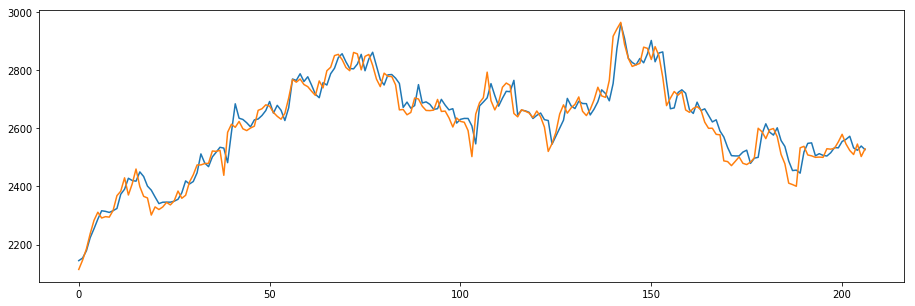

In [262]:
plt.figure(figsize=(15.5,5))
rmse(train_predictions,train_prices)


Test RMSE: 138.329


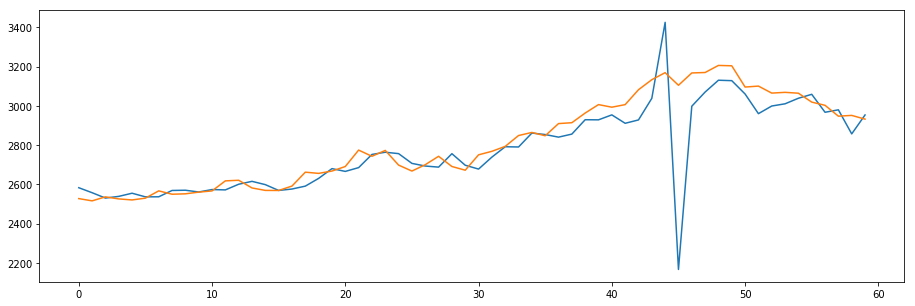

In [263]:
plt.figure(figsize=(15.5,5))
rmse(val_predictions,val_prices)


Test RMSE: 97.910


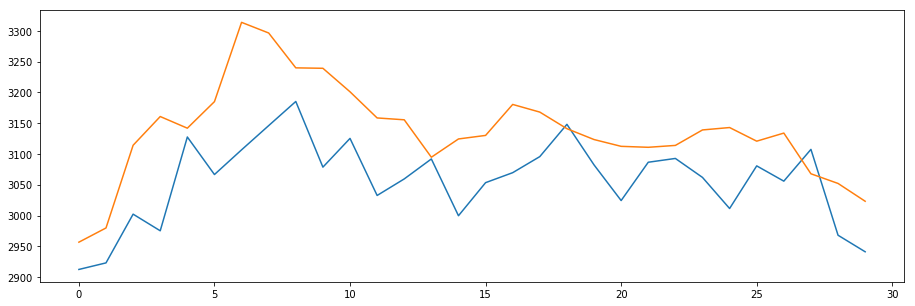

In [264]:
plt.figure(figsize=(15.5,5))
rmse(test_predictions,test_prices)

In [268]:
raw_test = read_test('data/stocks_test/stock_3.csv',3)
raw_test = append_past_days_data(raw_test,unscaled_params,2)
scaled_raw_test = Scale(raw_test,param_scaler)[0]
test = preprocess_x(scaled_raw_test,2)
test.shape

(97, 2, 7)

In [269]:
raw_submission_predictions = model.predict(test)
submission_predictions = close_scaler.inverse_transform(raw_submission_predictions)
pd.DataFrame(submission_predictions).describe().T

,count,mean,std,min,25%,50%,75%,max
0,97.0,2988.281982,146.210526,2652.512207,2895.002686,3029.140869,3098.603516,3235.085449


In [270]:
submission['Close-Stock-3'] = pd.DataFrame(submission_predictions).set_index(submission.index)
submission.head()

,Close-Stock-1,Close-Stock-2,Close-Stock-3,Close-Stock-4,Close-Stock-5
Date,,,,,
2011-08-04,890.214905,205.371414,3005.894531,0.0,0.0
2011-08-05,889.428833,201.313705,3029.140869,0.0,0.0
2011-08-08,879.970703,192.768097,2976.180420,0.0,0.0
2011-08-09,832.845947,192.253708,3014.277344,0.0,0.0
2011-08-10,804.529968,191.535629,2990.223633,0.0,0.0


## Stock 4

In [271]:
s4 = read_data('data/stocks_train/stock_4.csv')
s4.head()

,Date,Open-Stock-4,Close-Stock-4,High-Stock-4,Low-Stock-4,VWAP-Stock-4,Turnover-Stock-4,Volume-Stock-4,OC4,HL4
0,2010-06-01,851.65,837.95,864.80,833.1,844.44,327474904340000,3878011,13.70,31.70
1,2010-06-02,844.70,842.30,849.90,823.0,838.31,278403743240000,3320996,2.40,26.90
2,2010-06-03,851.40,854.10,859.05,848.2,853.51,212910342645000,2494522,-2.70,10.85
3,2010-06-04,854.10,865.85,868.60,854.1,862.85,255740999120000,2963920,-11.75,14.50
4,2010-06-07,712.00,841.95,850.00,712.0,839.89,291567400640000,3471483,-129.95,138.00


In [272]:
all_dates,unscaled_close_p,unscaled_params = dates_close_features(s4,4)
unscaled_params.shape,unscaled_close_p.shape,all_dates.shape

((299, 7), (299, 1), (299,))

In [273]:
params,param_scaler = Scale(unscaled_params)
close,close_scaler = Scale(unscaled_close_p)

In [274]:
reshaped_params = preprocess_x(params,2)
reshaped_params.shape

(297, 2, 7)

In [275]:
y = preprocess_y(close,2)
y.shape

(297, 1)

In [276]:
t_idx,v_idx,train_x,val_x,test_x = train_val_test_split(reshaped_params)

Indexes for train,val and test set
(0, 206) (207, 266) (267, 296)


In [277]:
t_i,v_i,train_y,val_y,test_y = train_val_test_split(y)

Indexes for train,val and test set
(0, 206) (207, 266) (267, 296)


In [278]:
train_x.shape,train_y.shape

((207, 2, 7), (207, 1))

In [279]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(train_x.shape[1],train_x.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = "mean_squared_error",optimizer="adam")

In [280]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 2, 50)             11600     
_________________________________________________________________
lstm_31 (LSTM)               (None, 2, 50)             20200     
_________________________________________________________________
lstm_32 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 52,051
Trainable params: 52,051
Non-trainable params: 0
_________________________________________________________________


In [281]:
history = model.fit(train_x,train_y,validation_data=(val_x,val_y),epochs=500,batch_size=23,verbose = 1)

Epoch 301/500
9/9 [==============================] - 0s 29ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 302/500
9/9 [==============================] - 0s 26ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 303/500
9/9 [==============================] - 0s 26ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 304/500
9/9 [==============================] - 0s 26ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 305/500
9/9 [==============================] - 0s 26ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 306/500
9/9 [==============================] - 0s 28ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 307/500
9/9 [==============================] - 0s 31ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 308/500
9/9 [==============================] - 0s 25ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 309/500
9/9 [==============================] - 0s 28ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 310/500
9/9 [==============================] - 0s 25ms/step - loss: 0.0024 - val_loss: 0.0014


In [282]:
raw_train_predictions = model.predict(train_x)
raw_val_predictions = model.predict(val_x)
raw_test_predictions = model.predict(test_x)

In [283]:
train_predictions = close_scaler.inverse_transform(raw_train_predictions)
val_predictions = close_scaler.inverse_transform(raw_val_predictions)
test_predictions = close_scaler.inverse_transform(raw_test_predictions)
train_prices =  close_scaler.inverse_transform(train_y)
val_prices = close_scaler.inverse_transform(val_y)
test_prices = close_scaler.inverse_transform(test_y)


Test RMSE: 20.999


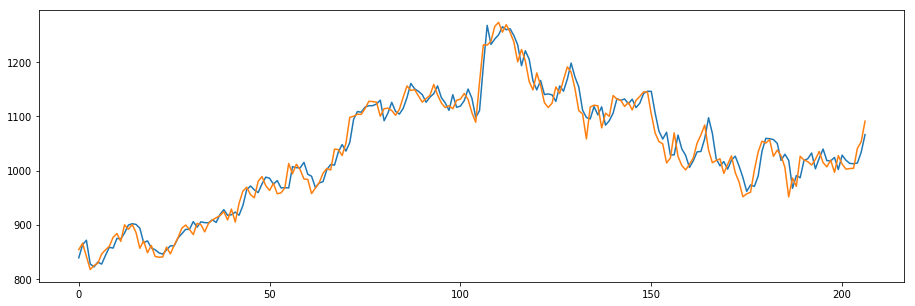

In [284]:
plt.figure(figsize=(15.5,5))
rmse(train_predictions,train_prices)


Test RMSE: 18.338


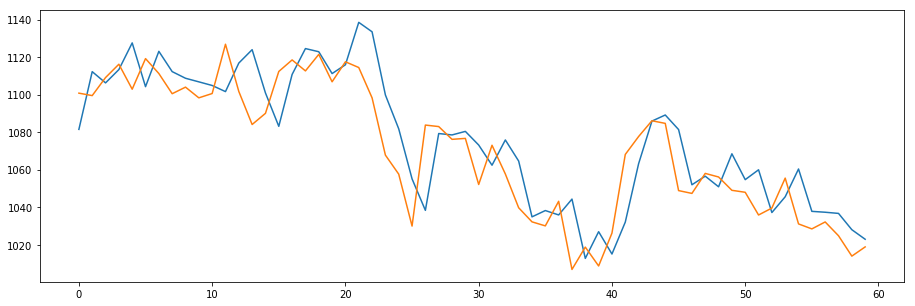

In [285]:
plt.figure(figsize=(15.5,5))
rmse(val_predictions,val_prices)


Test RMSE: 15.884


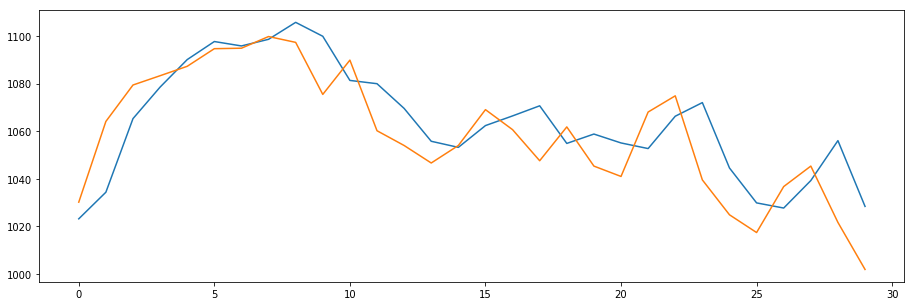

In [286]:
plt.figure(figsize=(15.5,5))
rmse(test_predictions,test_prices)

In [287]:
raw_test = read_test('data/stocks_test/stock_4.csv',4)
raw_test = append_past_days_data(raw_test,unscaled_params,2)
scaled_raw_test = Scale(raw_test,param_scaler)[0]
test = preprocess_x(scaled_raw_test,2)
test.shape

(97, 2, 7)

In [288]:
raw_submission_predictions = model.predict(test)
submission_predictions = close_scaler.inverse_transform(raw_submission_predictions)
pd.DataFrame(submission_predictions).describe().T

,count,mean,std,min,25%,50%,75%,max
0,97.0,834.732361,85.468155,641.140564,768.336121,856.207581,885.871521,1006.009216


In [289]:
submission['Close-Stock-4'] = pd.DataFrame(submission_predictions).set_index(submission.index)
submission.head()

,Close-Stock-1,Close-Stock-2,Close-Stock-3,Close-Stock-4,Close-Stock-5
Date,,,,,
2011-08-04,890.214905,205.371414,3005.894531,1000.282959,0.0
2011-08-05,889.428833,201.313705,3029.140869,1006.009216,0.0
2011-08-08,879.970703,192.768097,2976.180420,960.772583,0.0
2011-08-09,832.845947,192.253708,3014.277344,956.489075,0.0
2011-08-10,804.529968,191.535629,2990.223633,943.353943,0.0


## Stock 5

In [306]:
s5 = read_data('data/stocks_train/stock_5.csv')
s5.head()

,Date,Open-Stock-5,Close-Stock-5,High-Stock-5,Low-Stock-5,VWAP-Stock-5,Turnover-Stock-5,Volume-Stock-5,OC5,HL5
0,2010-06-01,1235.0,1181.70,1238.00,1177.0,1197.29,213845404410000,1786082,53.30,61.00
1,2010-06-02,1195.0,1201.15,1206.95,1168.5,1189.87,155564994855000,1307410,-6.15,38.45
2,2010-06-03,1211.0,1242.30,1248.00,1211.0,1231.63,182640434320000,1482919,-31.30,37.00
3,2010-06-04,1240.0,1245.45,1258.00,1240.0,1249.72,181767075850000,1454459,-5.45,18.00
4,2010-06-07,1218.6,1214.80,1225.00,1196.0,1209.27,172272511430000,1424594,3.80,29.00


In [333]:
all_dates,unscaled_close_p,unscaled_params = dates_close_features(s5,5)
unscaled_params.shape,unscaled_close_p.shape,all_dates.shape

((299, 7), (299, 1), (299,))

In [334]:
unscaled_params.head()

,Open-Stock-5,High-Stock-5,Low-Stock-5,VWAP-Stock-5,Turnover-Stock-5,Volume-Stock-5,HL5
Date,,,,,,,
2010-06-01,1235.0,1238.00,1177.0,1197.29,213845404410000,1786082,61.00
2010-06-02,1195.0,1206.95,1168.5,1189.87,155564994855000,1307410,38.45
2010-06-03,1211.0,1248.00,1211.0,1231.63,182640434320000,1482919,37.00
2010-06-04,1240.0,1258.00,1240.0,1249.72,181767075850000,1454459,18.00
2010-06-07,1218.6,1225.00,1196.0,1209.27,172272511430000,1424594,29.00


In [335]:
params,param_scaler = Scale(unscaled_params)
close,close_scaler = Scale(unscaled_close_p)

In [336]:
reshaped_params = preprocess_x(params,2)
reshaped_params.shape

(297, 2, 7)

In [337]:
y = preprocess_y(close,2)
y.shape

(297, 1)

In [338]:
t_idx,v_idx,train_x,val_x,test_x = train_val_test_split(reshaped_params)

Indexes for train,val and test set
(0, 206) (207, 266) (267, 296)


In [339]:
t_i,v_i,train_y,val_y,test_y = train_val_test_split(y)

Indexes for train,val and test set
(0, 206) (207, 266) (267, 296)


In [340]:
train_x.shape,train_y.shape

((207, 2, 7), (207, 1))

In [341]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(train_x.shape[1],train_x.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = "mean_squared_error",optimizer="adam")

In [342]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 2, 50)             11600     
_________________________________________________________________
lstm_40 (LSTM)               (None, 2, 50)             20200     
_________________________________________________________________
lstm_41 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 52,051
Trainable params: 52,051
Non-trainable params: 0
_________________________________________________________________


In [343]:
history = model.fit(train_x,train_y,validation_data=(val_x,val_y),epochs=500,batch_size=23,verbose = 1)

Epoch 301/500
9/9 [==============================] - 0s 27ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 302/500
9/9 [==============================] - 0s 33ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 303/500
9/9 [==============================] - 0s 28ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 304/500
9/9 [==============================] - 0s 29ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 305/500
9/9 [==============================] - 0s 30ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 306/500
9/9 [==============================] - 0s 26ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 307/500
9/9 [==============================] - 0s 26ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 308/500
9/9 [==============================] - 0s 29ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 309/500
9/9 [==============================] - 0s 27ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 310/500
9/9 [==============================] - 0s 25ms/step - loss: 0.0036 - val_loss: 0.0035


In [344]:
raw_train_predictions = model.predict(train_x)
raw_val_predictions = model.predict(val_x)
raw_test_predictions = model.predict(test_x)

In [345]:
train_predictions = close_scaler.inverse_transform(raw_train_predictions)
val_predictions = close_scaler.inverse_transform(raw_val_predictions)
test_predictions = close_scaler.inverse_transform(raw_test_predictions)
train_prices =  close_scaler.inverse_transform(train_y)
val_prices = close_scaler.inverse_transform(val_y)
test_prices = close_scaler.inverse_transform(test_y)


Test RMSE: 24.710


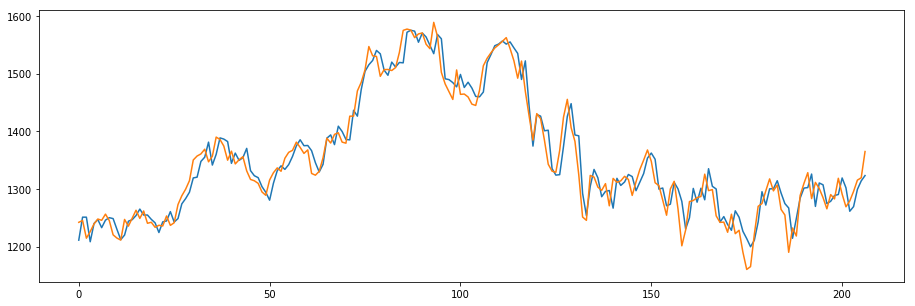

In [346]:
plt.figure(figsize=(15.5,5))
rmse(train_predictions,train_prices)


Test RMSE: 26.285


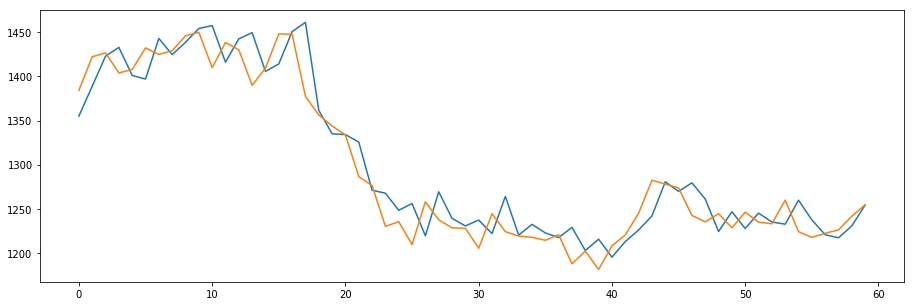

In [347]:
plt.figure(figsize=(15.5,5))
rmse(val_predictions,val_prices)


Test RMSE: 24.672


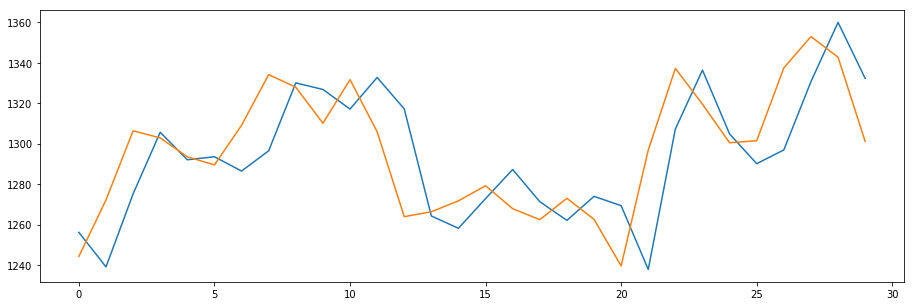

In [348]:
plt.figure(figsize=(15.5,5))
rmse(test_predictions,test_prices)

In [349]:
raw_test = read_test('data/stocks_test/stock_5.csv',5)
raw_test = append_past_days_data(raw_test,unscaled_params,2)
scaled_raw_test = Scale(raw_test,param_scaler)[0]
test = preprocess_x(scaled_raw_test,2)
test.shape

(97, 2, 7)

In [350]:
raw_submission_predictions = model.predict(test)
submission_predictions = close_scaler.inverse_transform(raw_submission_predictions)
pd.DataFrame(submission_predictions).describe().T

,count,mean,std,min,25%,50%,75%,max
0,97.0,1183.30603,30.791553,1135.462402,1160.722168,1175.066406,1197.296509,1291.711792


In [351]:
submission['Close-Stock-5'] = pd.DataFrame(submission_predictions).set_index(submission.index)
submission.head()

,Close-Stock-1,Close-Stock-2,Close-Stock-3,Close-Stock-4,Close-Stock-5
Date,,,,,
2011-08-04,890.214905,205.371414,3005.894531,1000.282959,1291.711792
2011-08-05,889.428833,201.313705,3029.140869,1006.009216,1288.227295
2011-08-08,879.970703,192.768097,2976.180420,960.772583,1213.169067
2011-08-09,832.845947,192.253708,3014.277344,956.489075,1263.301758
2011-08-10,804.529968,191.535629,2990.223633,943.353943,1237.229126


# preparing submission csv

In [352]:
submission.to_csv('submissions/LSTM/submission.csv')

In [353]:
submission.shape

(97, 5)

result rank = 172
result score = 692 (order according to rmse)

# END

In [55]:
#data attributes
attr = {'C1': 'Close-Stock-1',
 'C2': 'Close-Stock-2',
 'C3': 'Close-Stock-3',
 'C4': 'Close-Stock-4',
 'C5': 'Close-Stock-5',
 'H1': 'High-Stock-1',
 'H2': 'High-Stock-2',
 'H3': 'High-Stock-3',
 'H4': 'High-Stock-4',
 'H5': 'High-Stock-5',
 'L1': 'Low-Stock-1',
 'L2': 'Low-Stock-2',
 'L3': 'Low-Stock-3',
 'L4': 'Low-Stock-4',
 'L5': 'Low-Stock-5',
 'O1': 'Open-Stock-1',
 'O2': 'Open-Stock-2',
 'O3': 'Open-Stock-3',
 'O4': 'Open-Stock-4',
 'O5': 'Open-Stock-5',
 'TO1': 'Turnover-Stock-1',
 'TO2': 'Turnover-Stock-2',
 'TO3': 'Turnover-Stock-3',
 'TO4': 'Turnover-Stock-4',
 'TO5': 'Turnover-Stock-5',
 'V1': 'Volume-Stock-1',
 'V2': 'Volume-Stock-2',
 'V3': 'Volume-Stock-3',
 'V4': 'Volume-Stock-4',
 'V5': 'Volume-Stock-5',
 'VWAP1': 'VWAP-Stock-1',
 'VWAP2': 'VWAP-Stock-2',
 'VWAP3': 'VWAP-Stock-3',
 'VWAP4': 'VWAP-Stock-4',
 'VWAP5': 'VWAP-Stock-5',
 'idx': 'Date'}